# AMICI Python example "splines"

This is an example showing how to add spline assignment rules to a pre-existing SBML model.

A full application example of using splines to parametrize time-dependent unknown inputs followed by parameter estimation with pypesto can be found in the [pypesto documentation](https://pypesto.readthedocs.io/en/latest/example.html#application-examples).

### Utility functions

In [1]:
import os
from shutil import rmtree
from tempfile import TemporaryDirectory
from uuid import uuid1

import amici
import matplotlib as mpl
import numpy as np
import sympy as sp
from amici.sim.sundials import (
    SensitivityMethod,
    SensitivityOrder,
    run_simulation,
)
from matplotlib import pyplot as plt

# Choose build directory
BUILD_PATH = None  # temporary folder
# BUILD_PATH = 'build' # specified folder for debugging
if BUILD_PATH is not None:
    # Remove previous models
    rmtree(BUILD_PATH, ignore_errors=True)
    os.mkdir(BUILD_PATH)


def simulate(sbml_model, parameters=None, *, model_name=None, **kwargs):
    if model_name is None:
        model_name = "model_" + uuid1().hex
    if BUILD_PATH is None:
        with TemporaryDirectory() as build_dir:
            return _simulate(
                sbml_model,
                parameters,
                build_dir=build_dir,
                model_name=model_name,
                **kwargs,
            )
    else:
        build_dir = os.path.join(BUILD_PATH, model_name)
        rmtree(build_dir, ignore_errors=True)
        return _simulate(
            sbml_model,
            parameters,
            build_dir=build_dir,
            model_name=model_name,
            **kwargs,
        )


def _simulate(
    sbml_model,
    parameters,
    *,
    build_dir,
    model_name,
    T=1,
    discard_annotations=False,
    plot=True,
):
    if parameters is None:
        parameters = {}
    # Build the model module from the SBML file
    sbml_importer = amici.SbmlImporter(
        sbml_model, discard_annotations=discard_annotations
    )
    sbml_importer.sbml2amici(model_name, build_dir)
    # Import the model module
    model_module = amici.import_model_module(model_name, build_dir)
    # Setup simulation timepoints and parameters
    model = model_module.get_model()
    for name, value in parameters.items():
        model.set_free_parameter_by_name(name, value)
    if isinstance(T, int | float):
        T = np.linspace(0, T, 100)
    model.set_timepoints([float(t) for t in T])
    solver = model.create_solver()
    solver.set_sensitivity_order(SensitivityOrder.first)
    solver.set_sensitivity_method(SensitivityMethod.forward)
    # Simulate
    rdata = run_simulation(model, solver)
    # Plot results
    if plot:
        fig, ax = plt.subplots()
        ax.plot(rdata["t"], rdata["x"])
        ax.set_xlabel("time")
        ax.set_ylabel("concentration")
    return model, rdata

### A simple SBML model

Let us consider the following SBML model:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level2/version5" level="2" version="5">
  <model id="example_splines">
    <listOfCompartments>
      <compartment id="compartment" size="1"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="x" compartment="compartment" initialAmount="0"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="f" constant="false"/>
    </listOfParameters>
    <listOfRules>
      <rateRule variable="x">
        <math xmlns="http://www.w3.org/1998/Math/MathML">
          <ci> f </ci>
        </math>
      </rateRule>
    </listOfRules>
  </model>
</sbml>
```

This model corresponds to the simple ODE $\dot{x} = f$ for a species $x$ and a parameter $f$.

We can easily import and simulate this model in AMICI.

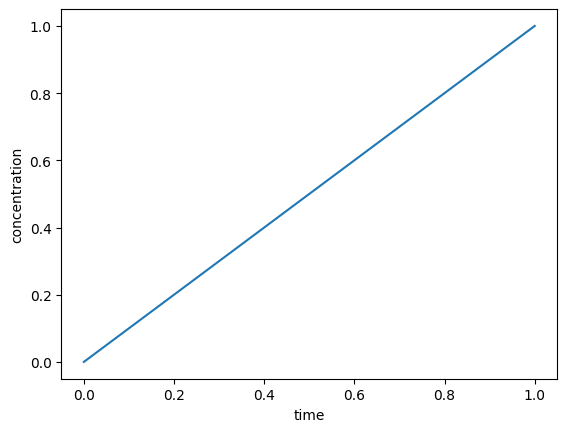

In [2]:
simulate("example_splines.xml", dict(f=1));

### Adding a simple spline

Instead of using a constant parameter $f$, we want to use a smooth time-dependent function $f(t)$ whose value is known only at a finite number of time instants. The value of $f(t)$ outside such grid points needs to be smoothly interpolated. Several methods have been developed for this problem over the years; AMICI at the moment supports only [cubic Hermite splines](https://en.wikipedia.org/wiki/Cubic_Hermite_spline).

We can add a spline function to an existing SBML model with the following code. The resulting time-dependent parameter $f(t)$ will assume values $(1, -0.5, 2)$ at the equally spaced points $(0, 0.5, 1)$ and smoothly vary elsewhere.

AMICI encodes the spline as a SBML assignment rule for the parameter $f$. Such a rule consists of a piecewise-polynomial formula which can be interpreted in any SBML-compliant software. However, such very complex formulas are computationally inefficient; e.g., in AMICI they lead to very long model creation times. To solve such problem the code below adds AMICI-specific SBML annotations to the assignment rule which can be used by AMICI to recreate the correct interpolant without reading the inefficient piecewise formula.

In [3]:
# Create a spline object
from amici.importers.sbml.splines import CubicHermiteSpline, UniformGrid
from amici.importers.utils import amici_time_symbol

spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,  # the spline function is evaluated at the current time point
    nodes=UniformGrid(0, 1, number_of_nodes=3),
    values_at_nodes=[1, -1, 2],
)

In [4]:
# This spline object can be evaluated at any point
# and so can its derivative/integral
print(f"spline value at 0.3 = {spline.evaluate(0.3)}")
print(f"spline derivative at 0.3 = {spline.derivative(0.3)}")
print(f"spline integral between 0 and 1 = {spline.integrate(0.0, 1.0)}")

spline value at 0.3 = -0.560000000000000
spline derivative at 0.3 = -4.60000000000000
spline integral between 0 and 1 = 0.0416666666666672


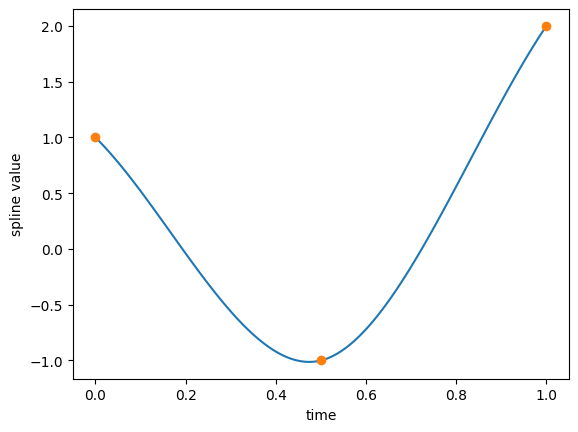

In [5]:
# Plot the spline
spline.plot(xlabel="time");

In [6]:
# Load SBML model using libsbml
import libsbml

sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
sbml_model = sbml_doc.getModel()
# We can add the spline assignment rule to the SBML model
spline.add_to_sbml_model(sbml_model)

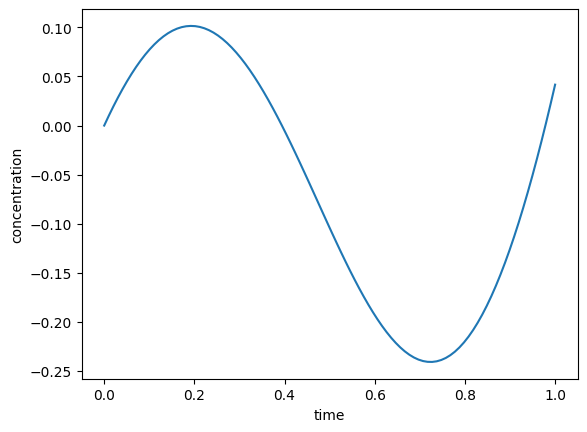

In [7]:
# Finally, we can simulate it in AMICI
model, rdata = simulate(sbml_model)

In [8]:
# Final value should be equal to the integral computed above
assert np.allclose(rdata["x"][-1], float(spline.integrate(0.0, 1.0)))

The following is the SBML code for the above model
```xml
<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level2/version5" level="2" version="5">
  <model id="example_splines">
    <listOfCompartments>
      <compartment id="compartment" size="1"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="x" compartment="compartment" initialAmount="0"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="f" constant="false"/>
    </listOfParameters>
    <listOfRules>
      <rateRule variable="x">
        <math xmlns="http://www.w3.org/1998/Math/MathML">
          <ci> f </ci>
        </math>
      </rateRule>
      <assignmentRule variable="f">
        <annotation>
          <amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite">
            <amici:spline_evaluation_point>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <csymbol encoding="text" definitionURL="http://www.sbml.org/sbml/symbols/time"> time </csymbol>
              </math>
            </amici:spline_evaluation_point>
            <amici:spline_uniform_grid>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <cn>0</cn>
              </math>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <cn>1</cn>
              </math>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <apply>
                  <divide/>
                  <cn>1</cn>
                  <cn>2</cn>
                </apply>
              </math>
            </amici:spline_uniform_grid>
            <amici:spline_values>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <cn>1</cn>
              </math>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <cn>-1</cn>
              </math>
              <math xmlns="http://www.w3.org/1998/Math/MathML">
                <cn>2</cn>
              </math>
            </amici:spline_values>
          </amici:spline>
        </annotation>
        <math xmlns="http://www.w3.org/1998/Math/MathML">
          <piecewise>
            ... piecewise representation of the spline ...
          </piecewise>
        </math>
      </assignmentRule>
    </listOfRules>
  </model>
</sbml>
```

The spline annotation on its own can be accessed by

In [9]:
print(spline.amici_annotation)

<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite">
	<amici:spline_evaluation_point>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<csymbol encoding="text" definitionURL="http://www.sbml.org/sbml/symbols/time"> time </csymbol>
		</math>
	</amici:spline_evaluation_point>
	<amici:spline_uniform_grid>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>0</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>1</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<apply>
				<divide/>
				<cn>1</cn>
				<cn>2</cn>
			</apply>
		</math>
	</amici:spline_uniform_grid>
	<amici:spline_values>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>1</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>-1</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>2</cn>
		</math>
	</amici:spline_values>
</amici:spline>


### Splines can be parametrized

Instead of constant values, SBML parameters can be used as spline values. These can also be automatically added to the model when adding the assignment rule.

In [10]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=3),
    values_at_nodes=sp.symbols("f0:3"),
)

In [11]:
sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(
    sbml_model,
    auto_add=True,
    y_nominal=[1, -0.5, 2],
)

In [12]:
parameters = dict(f0=-2, f1=1, f2=-2)

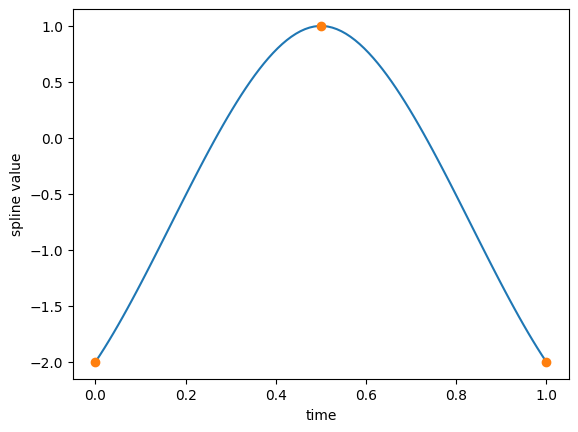

In [13]:
spline.plot(parameters, xlabel="time");

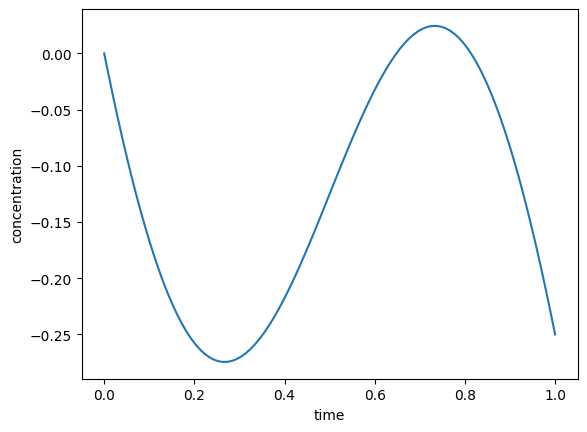

In [14]:
model, rdata = simulate(sbml_model, parameters)

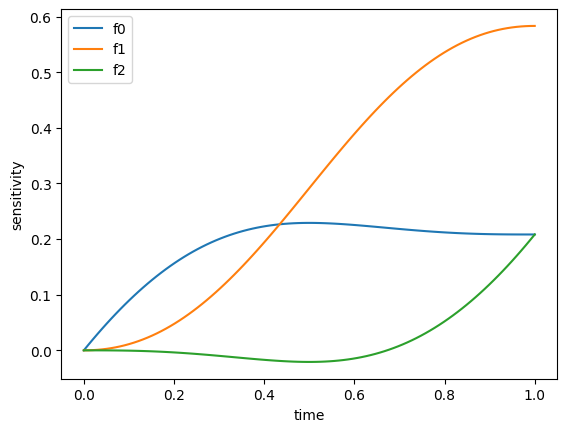

In [15]:
# Sensitivities with respect to the spline values can be computed
fig, ax = plt.subplots()
ax.plot(rdata["t"], rdata.sx[:, 0], label=model.get_free_parameter_names()[0])
ax.plot(rdata["t"], rdata.sx[:, 1], label=model.get_free_parameter_names()[1])
ax.plot(rdata["t"], rdata.sx[:, 2], label=model.get_free_parameter_names()[2])
ax.set_xlabel("time")
ax.set_ylabel("sensitivity")
ax.legend();

### Specifying derivatives, boundary conditions and extrapolation methods

When derivatives are not specified in the `CubicHermiteSpline` constructor, they are computed automatically using finite differences and according to the boundary conditions. If their form is known a priori (e.g., they are known constants or functions of parameters), they can be passed explicitly to the spline constructor.

In [16]:
# A simple spline for which finite differencing would give a different result
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=3),
    values_at_nodes=[1.0, -1.0, 1.0],
    derivatives_at_nodes=[10.0, -10.0, -10.0],
)

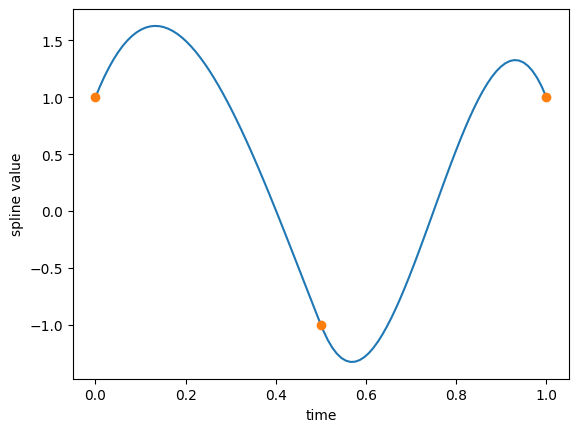

In [17]:
spline.plot(xlabel="time");

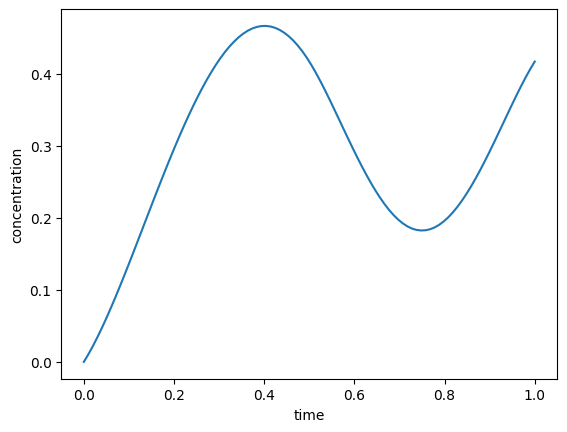

In [18]:
# Simulation
sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model)
simulate(sbml_model, T=1);

The spline annotation in this case is
```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
	<amici:spline_derivatives>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>10</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>-10</cn>
		</math>
		<math xmlns="http://www.w3.org/1998/Math/MathML">
			<cn>-10</cn>
		</math>
	</amici:spline_derivatives>
</amici:spline>
```

---
The default boundary conditions depend on the extrapolation method (which defaults to no extrapolation). For example, below we have a spline with constant extrapolation.

In [19]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=3),
    values_at_nodes=[-2, 1, -1],
    extrapolate=(
        None,
        "constant",
    ),  # no extrapolation required on the left side
)

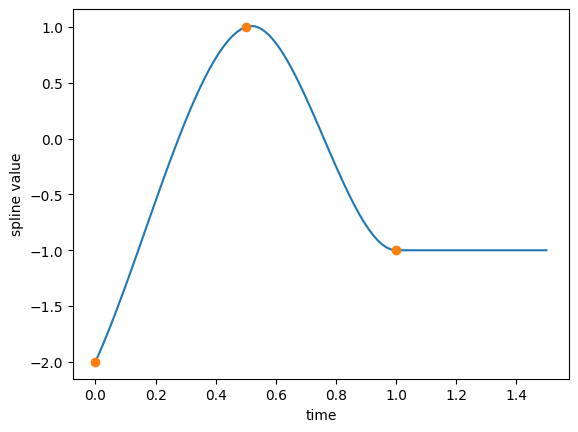

In [20]:
spline.plot(xlabel="time", xlim=(0, 1.5));

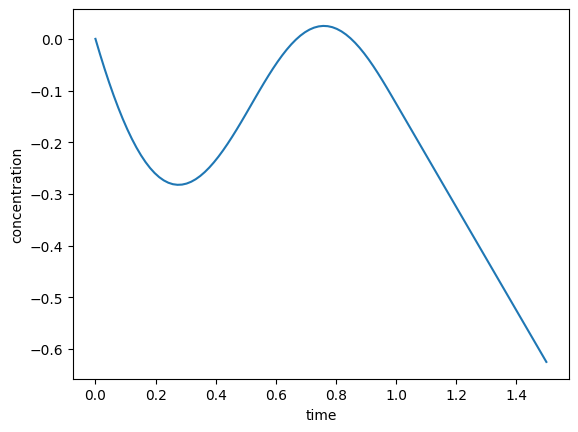

In [21]:
sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model)
simulate(sbml_model, T=1.5);

The spline annotation in this case is
```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite" amici:spline_bc="(no_bc, zeroderivative)" amici:spline_extrapolate="(no_extrapolation, constant)">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
</amici:spline>
```

---

And here we have a periodic spline.

In [22]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=3),
    values_at_nodes=[-2, 1, -2],  # first and last node must coincide
    extrapolate="periodic",
)

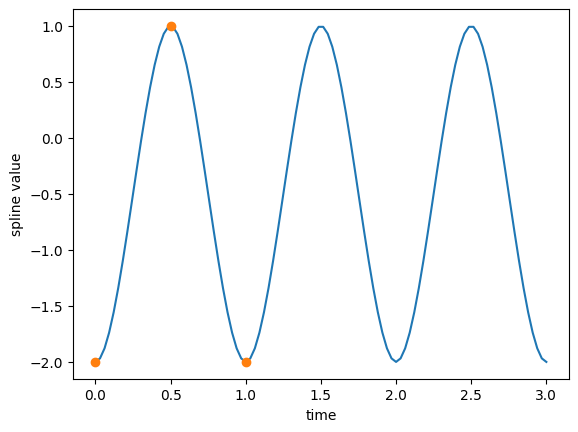

In [23]:
spline.plot(xlabel="time", xlim=(0, 3));

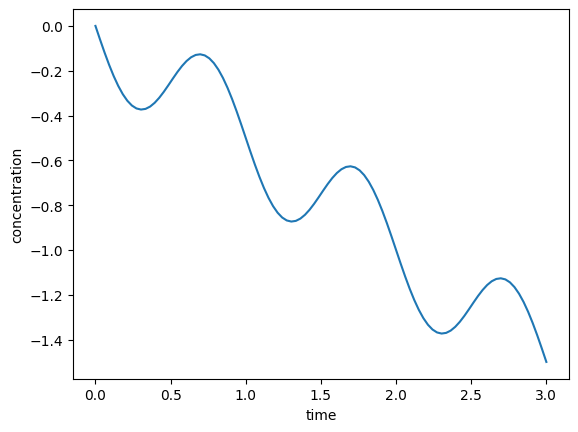

In [24]:
sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model)
simulate(sbml_model, T=3);

The spline annotation in this case is
```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite" amici:spline_bc="periodic" amici:spline_extrapolate="periodic">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
</amici:spline>
```

---

We can modify the spline's boundary conditions, for example requiring that the derivatives is zero.

In [25]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=4),
    values_at_nodes=[-1, 2, 4, 2],
    bc="zeroderivative",
)

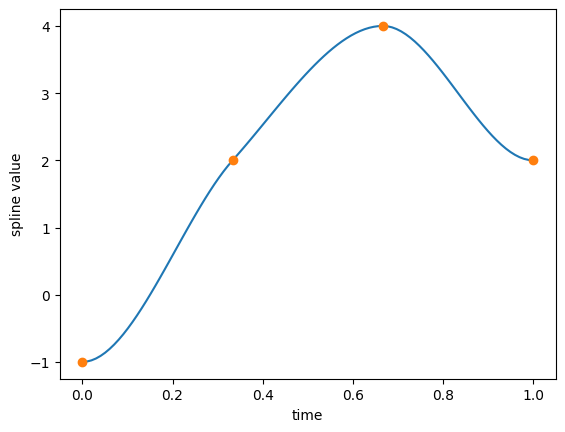

In [26]:
spline.plot(xlabel="time");

```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite" amici:spline_bc="zeroderivative">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
</amici:spline>
```

Or we can impose natural boundary conditions.

In [27]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=4),
    values_at_nodes=[-1, 2, 4, 2],
    bc="natural",
)

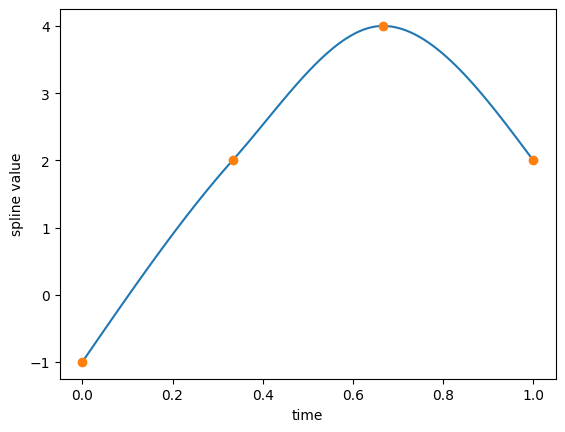

In [28]:
spline.plot(xlabel="time");

```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite" amici:spline_bc="natural">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
</amici:spline>
```

---

Even if all node values are positive, due to under-shooting a cubic Hermite spline can assume negative values. In certain settings (e.g., when the spline represents a chemical reaction rate) this should be avoided. A possible solution is to carry out the interpolation in log-space (the resulting function is no longer a spline, but it is still a smooth interpolant).

In [29]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=5),
    values_at_nodes=[2, 0.05, 0.1, 2, 1],
)

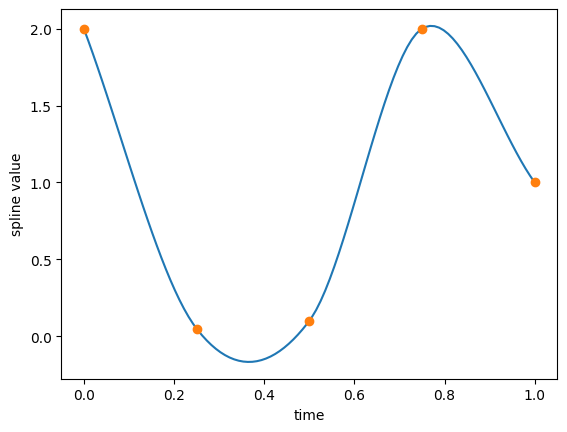

In [30]:
# This spline assumes negative values!
spline.plot(xlabel="time");

In [31]:
spline = CubicHermiteSpline(
    sbml_id="f",
    evaluate_at=amici_time_symbol,
    nodes=UniformGrid(0, 1, number_of_nodes=5),
    values_at_nodes=[2, 0.05, 0.1, 2, 1],
    logarithmic_parametrization=True,
)

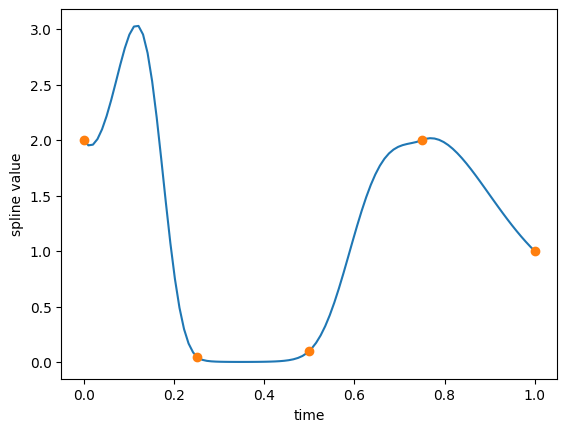

In [33]:
# Instead of under-shooting we now have over-shooting,
# but at least the "spline" is always positive
spline.plot(xlabel="time");

The spline annotation in this case is
```xml
<amici:spline xmlns:amici="https://github.com/AMICI-dev/AMICI" amici:spline_method="cubic_hermite" amici:spline_logarithmic_parametrization="true">
	<amici:spline_evaluation_point> ... </amici:spline_evaluation_point>
	<amici:spline_uniform_grid> ... </amici:spline_uniform_grid>
	<amici:spline_values> ... </amici:spline_values>
</amici:spline>
```

### Comparing model import time for the SBML-native piecewise implementation and the AMICI spline implementation

In [33]:
import tempfile
import time

import pandas as pd

In [34]:
nruns = 6  # number of replicates
num_nodes = [
    5,
    10,
    15,
    20,
    25,
    30,
    40,
]  # benchmark model import for these node numbers
amici_only_nodes = [
    50,
    75,
    100,
    125,
    150,
    175,
    200,
    225,
    250,
]  # for these node numbers, only benchmark the annotation-based implementation

In [35]:
# If running as a GitHub action, just do the minimal amount of work required to check whether the code is working
if os.getenv("GITHUB_ACTIONS") is not None:
    nruns = 1
    num_nodes = [4]
    amici_only_nodes = [5]

In [36]:
df = None
for n in num_nodes + amici_only_nodes:
    # Create model
    spline = CubicHermiteSpline(
        sbml_id="f",
        evaluate_at=amici_time_symbol,
        nodes=UniformGrid(0, 1, number_of_nodes=n),
        values_at_nodes=np.random.rand(n),
    )
    sbml_doc = libsbml.SBMLReader().readSBML("example_splines.xml")
    sbml_model = sbml_doc.getModel()
    spline.add_to_sbml_model(sbml_model)
    # Benchmark model creation
    timings_amici = []
    timings_piecewise = []
    for _ in range(nruns):
        with tempfile.TemporaryDirectory() as tmpdir:
            t0 = time.perf_counter_ns()
            amici.SbmlImporter(sbml_model).sbml2amici("benchmark", tmpdir)
            dt = time.perf_counter_ns() - t0
            timings_amici.append(dt / 1e9)
        if n in num_nodes:
            with tempfile.TemporaryDirectory() as tmpdir:
                t0 = time.perf_counter_ns()
                amici.SbmlImporter(
                    sbml_model, discard_annotations=True
                ).sbml2amici("benchmark", tmpdir)
                dt = time.perf_counter_ns() - t0
                timings_piecewise.append(dt / 1e9)
    # Append benchmark data to dataframe
    df_amici = pd.DataFrame(
        dict(num_nodes=n, time=timings_amici, use_annotations=True)
    )
    df_piecewise = pd.DataFrame(
        dict(num_nodes=n, time=timings_piecewise, use_annotations=False)
    )
    if df is None:
        df = pd.concat(
            [df_amici, df_piecewise], ignore_index=True, verify_integrity=True
        )
    else:
        df = pd.concat(
            [df, df_amici, df_piecewise],
            ignore_index=True,
            verify_integrity=True,
        )

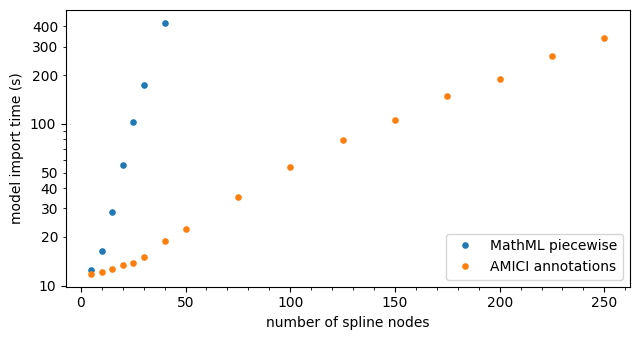

In [88]:
kwargs = dict(markersize=7.5)
df_avg = df.groupby(["use_annotations", "num_nodes"]).mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
ax.plot(
    df_avg[np.logical_not(df_avg["use_annotations"])]["num_nodes"],
    df_avg[np.logical_not(df_avg["use_annotations"])]["time"],
    ".",
    label="MathML piecewise",
    **kwargs,
)
ax.plot(
    df_avg[df_avg["use_annotations"]]["num_nodes"],
    df_avg[df_avg["use_annotations"]]["time"],
    ".",
    label="AMICI annotations",
    **kwargs,
)
ax.set_ylabel("model import time (s)")
ax.set_xlabel("number of spline nodes")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: f"{x:.0f}")
)
ax.xaxis.set_ticks(
    [
        10,
        20,
        30,
        40,
        60,
        70,
        80,
        90,
        110,
        120,
        130,
        140,
        160,
        170,
        180,
        190,
        210,
        220,
        230,
        240,
        260,
    ],
    minor=True,
)
ax.yaxis.set_ticks(
    [20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400],
    ["20", "30", "40", "50", None, None, None, None, "200", "300", "400"],
    minor=True,
)
ax.legend()
ax.figure.tight_layout()
# ax.figure.savefig('benchmark_import.pdf')